In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from jax import jit
import jax.numpy as jnp
from ticktack import fitting, resample
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq
plt.rcParams['figure.figsize'] = (8.0, 6.0)
#from helper import run_resample, load_IntCal20
import pandas as pd
import scipy.signal
import statistics

In [2]:
#Generate a noisy signal
def noisy_signal(SNR,t,period):
    y = SNR*np.sin(2*np.pi*t/period)
    noise = np.random.randn(len(t))
    y_noise = y + noise
    return(y_noise)

In [3]:
def resample_signal(data_frame):
    resampler = resample.Resampler()
    resampler.load_data(data_frame.year, data_frame.d14c, data_frame.sig_d14c)
    resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
    new_signal = resampler.signal_resample(size=512)
    return(new_signal)

In [4]:
def norm_zero_signal(data_frame):
    new_signal=resample_signal(data_frame)
    zero_signal=new_signal.copy()
    nsamples = new_signal.shape[0]
    zero_signal -= new_signal.mean(axis=1)[:,None]
    norm_signal=zero_signal/np.sqrt((zero_signal**2).sum(axis=1))[:,None]
    return(norm_signal)

In [5]:
def covarience_matrix(signal):
    covmat = np.corrcoef(signal)
    return(covmat)

In [6]:
def remove_diag(matrix):
    off_diag = matrix[~np.eye(matrix.shape[0],dtype=bool)]
    return(off_diag)

In [7]:
t = np.arange(500)
period = 11.
truesnrs=np.arange(0.01,10.01,0.01)
means=np.zeros(1000)
sds=np.zeros(1000)
for SNR in range(len(truesnrs)):
    thesnr=SNR/np.sqrt(500)
    new_signal=noisy_signal(thesnr,t,period)
    errors=np.ones(len(new_signal))
    load_data={'year':t,
                'd14c':new_signal,
                'sig_d14c':errors}
    data=pd.DataFrame(load_data)
    signal=norm_zero_signal(data)
    full_matrix=covarience_matrix(signal)
    diagonal = remove_diag(full_matrix)
    means[SNR], sds[SNR] = np.nanmedian(diagonal), np.nanstd(diagonal)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0, 0.5, 'Median')

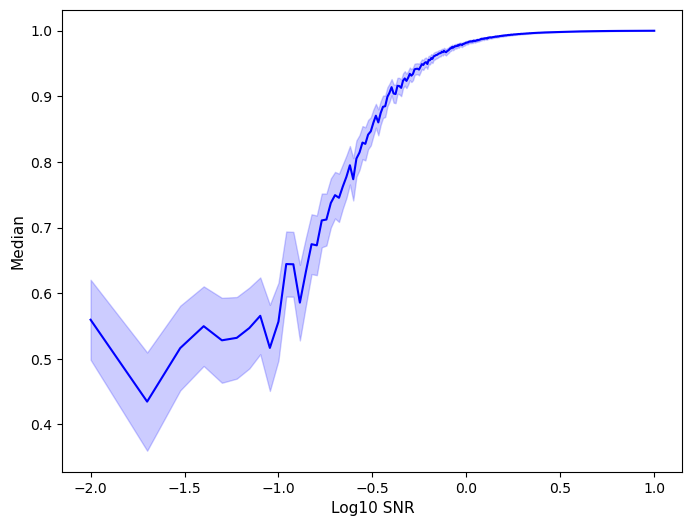

In [8]:
fig, axs = plt.subplots(1, figsize=(8, 6), sharex=True)
axs.fill_between(np.log10(truesnrs), means-sds, means+sds, color = 'b', alpha=0.2)
axs.plot(np.log10(truesnrs), means, color = 'b')
axs.set_xlabel("Log10 SNR",fontsize=11)
axs.set_ylabel("Median",fontsize=11)
